# Iterators

## Topics

- Stream larger-than-memory data through a pipeline
- Composable thanks to the iterator protocol

My favorite "feature" of pandas is that it's written in Python.
Python has great language-level features for handling streams of data
that may not fit in memory.
This can be a useful pre-processing step to reading the data into a DataFrame or
NumPy array.
You can get quite far using just the builtin data structures as David Beazley proves in [this PyData keynote](https://www.youtube.com/watch?v=lyDLAutA88s).

In [1]:
import os
import gzip
from itertools import islice, takewhile

import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
from toolz import partition_all, partitionby
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_rows = 10
sns.set(context='talk')
plt.style.use("default")

## Beer Reviews Dataset

- A review is a list of lines
- Each review line is formated like `meta/field: value`
- Reviews are separated by blank lines (i.e. the line is just `'\n'`)


Stanford has a [dataset on beer reviews](https://snap.stanford.edu/data/web-BeerAdvocate.html). The raw file is too large for me to include, but I split off a couple subsets for us to work with.

Pandas can't read this file natively, but we have Python!
We'll use Python to parse the raw file and tranform it into a tabular format.

In [4]:
with gzip.open("data/beer-raw-small.txt.gz", "r") as f:
    print(f.read(1500).decode('utf-8'))

beer/name: Sausa Weizen
beer/beerId: 47986
beer/brewerId: 10325
beer/ABV: 5.00
beer/style: Hefeweizen
review/appearance: 2.5
review/aroma: 2
review/palate: 1.5
review/taste: 1.5
review/overall: 1.5
review/time: 1234817823
review/profileName: stcules
review/text: A lot of foam. But a lot.	In the smell some banana, and then lactic and tart. Not a good start.	Quite dark orange in color, with a lively carbonation (now visible, under the foam).	Again tending to lactic sourness.	Same for the taste. With some yeast and banana.		

beer/name: Red Moon
beer/beerId: 48213
beer/brewerId: 10325
beer/ABV: 6.20
beer/style: English Strong Ale
review/appearance: 3
review/aroma: 2.5
review/palate: 3
review/taste: 3
review/overall: 3
review/time: 1235915097
review/profileName: stcules
review/text: Dark red color, light beige foam, average.	In the smell malt and caramel, not really light.	Again malt and caramel in the taste, not bad in the end.	Maybe a note of honey in teh back, and a light fruitiness.	Av

The full compressed raw dataset is about 500MB, so reading it all into memory might not be pleasent (we're working with a small subset that would fit in memory, but pretend it didn't).
Fortunately, Python's iterator protocol and generators make dealing with large streams of data pleasent.

## Developing a solution

Let's build a solution together. I'll provide some guidance as we go along.

In [5]:
# Get a handle to the data
f = gzip.open("data/beer-raw-small.txt.gz", "rt")
f.readline()

'beer/name: Sausa Weizen\n'

## Parsing Tasks

1. split the raw text stream into individual reviews
2. transform each individual review into a data container
3. combine a chunk of transformed individual reviews into a collection
4. store the chunk to disk

**Step 1**: Split the text stream

We'll use `toolz.partitionby`. It takes an iterator like `f`, and splits it according to `func`.

In [6]:
f.seek(0)  # Make the cell idempotent
split = partitionby(lambda x: x == '\n', f)
a, b = next(split), next(split)
a

('beer/name: Sausa Weizen\n',
 'beer/beerId: 47986\n',
 'beer/brewerId: 10325\n',
 'beer/ABV: 5.00\n',
 'beer/style: Hefeweizen\n',
 'review/appearance: 2.5\n',
 'review/aroma: 2\n',
 'review/palate: 1.5\n',
 'review/taste: 1.5\n',
 'review/overall: 1.5\n',
 'review/time: 1234817823\n',
 'review/profileName: stcules\n',
 'review/text: A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t\n')

In [7]:
b

('\n',)

So we've gone from

```python
[
    "beer/name: Susa Weizen\n",
    ...
    "review/text: ...\n",
    "\n",
    "beer/name: Beer 2\n",
    "...",
    "review/text: ...\n",
    "\n",
]
```

To

```python
[
    (
        "beer/name Susa Weizen\n",
        ...
        "review/text: ...\n"
    ),
    ("\n",),
    (
        "beer/name: Beer 2\n",
        ...
        "review/text: ...\n"
    ),
    ("\n",),
    ...
]
```

So we can clean up those newlines with a generator expression:

In [8]:
f.seek(0)
reviews = (x for x in partitionby(lambda x: x == "\n", f)
           if x != ("\n",))
reviews

<generator object <genexpr> at 0x1c0ba60c50>

**Step 2**: Parse each review

Let's grab out the first review, and turn it into something a bit nicer than a tuple of strings.

In [9]:
f.seek(0);  # make the cell idempotent
review = next(partitionby(lambda x: x == '\n', f))
review

('beer/name: Sausa Weizen\n',
 'beer/beerId: 47986\n',
 'beer/brewerId: 10325\n',
 'beer/ABV: 5.00\n',
 'beer/style: Hefeweizen\n',
 'review/appearance: 2.5\n',
 'review/aroma: 2\n',
 'review/palate: 1.5\n',
 'review/taste: 1.5\n',
 'review/overall: 1.5\n',
 'review/time: 1234817823\n',
 'review/profileName: stcules\n',
 'review/text: A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t\n')

<div class="alert alert-success" data-title="Format Review">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Format Review</h1>
</div>
<p>Write a function `format_review` that converts an item like `review` into a dict</p>

It will have one entry per line, where the are the stuff to the left of the colon and the values are the stuff to the right.
For example, the first line would be

`'beer/name: Sausa Weizen\n',` => `'beer/name': 'Sausa Weizen'`

Make sure to clean up the line endings too.

- Hint: Check out the [python string methods](https://docs.python.org/3/library/stdtypes.html#string-methods)

You can check your function against `expected` by evaluating the next cell.
If you get a failure, adjust your `format_review` until it passes.

In [10]:
import unittest
from typing import List, Dict

f.seek(0);  # make the cell idempotent
review = next(partitionby(lambda x: x == '\n', f))


def format_review(review: List[str]) -> Dict[str, str]:
    """Your code goes below"""
    formatted = ...
    return formatted
    

class TestFormat(unittest.TestCase):
    maxDiff = None

    def test_format_review(self):
        result = format_review(review)
        expected = {
            'beer/ABV': '5.00',
            'beer/beerId': '47986',
            'beer/brewerId': '10325',
            'beer/name': 'Sausa Weizen',
            'beer/style': 'Hefeweizen',
            'review/appearance': '2.5',
            'review/aroma': '2',
            'review/overall': '1.5',
            'review/palate': '1.5',
            'review/profileName': 'stcules',
            'review/taste': '1.5',
            'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t',
            'review/time': '1234817823'
        }
        self.assertEqual(result, expected)

suite = unittest.TestLoader().loadTestsFromModule(TestFormat())
unittest.TextTestRunner().run(suite)

F
FAIL: test_format_review (__main__.TestFormat)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-10-cd431c002d6d>", line 34, in test_format_review
    self.assertEqual(result, expected)
AssertionError: Ellipsis != {'beer/ABV': '5.00', 'beer/beerId': '4798[553 chars]823'}

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (failures=1)


<unittest.runner.TextTestResult run=1 errors=0 failures=1>

In [12]:
%load solutions/groupby_format_review.py

Notice that optional argument to split, which controls the number of splits made; If a review text had contained a literal `': '`, we'd be in trouble since it'd get split again.

Make sure you executed the above solution cell twice (first to load, second to execute) as we'll be using that `format_review` function down below

## To a DataFrame

Assuming we've processed many reviews into a list, we'll then build up a DataFrame.

In [13]:
r = [format_review(review)]  # imagine a list of many reviews

col_names = {
    'beer/ABV': 'abv',
    'beer/beerId': 'beer_id',
    'beer/brewerId': 'brewer_id',
    'beer/name': 'beer_name',
    'beer/style': 'beer_style',
    'review/appearance': 'review_appearance',
    'review/aroma': 'review_aroma',
    'review/overall': 'review_overall',
    'review/palate': 'review_palate',
    'review/profileName': 'profile_name',
    'review/taste': 'review_taste',
    'review/text': 'text',
    'review/time': 'time'
}
df = pd.DataFrame(r)
numeric = ['abv', 'review_appearance', 'review_aroma',
           'review_overall', 'review_palate', 'review_taste']
df = (df.rename(columns=col_names)
        .replace('', np.nan))
df[numeric] = df[numeric].astype(float)
df['time'] = pd.to_datetime(df.time.astype(int), unit='s')
df

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot.\tIn the smell some b...,2009-02-16 20:57:03


Again, writing that as a function:

In [44]:
def as_dataframe(reviews):
    df = pd.DataFrame(list(reviews))

    col_names = {
        'beer/ABV': 'abv',
        'beer/beerId': 'beer_id',
        'beer/brewerId': 'brewer_id',
        'beer/name': 'beer_name',
        'beer/style': 'beer_style',
        'review/appearance': 'review_appearance',
        'review/aroma': 'review_aroma',
        'review/overall': 'review_overall',
        'review/palate': 'review_palate',
        'review/profileName': 'profile_name',
        'review/taste': 'review_taste',
        'review/text': 'text',
        'review/time': 'time'
    }
    order = ['brewer_id', 'beer_id', 'beer_name',
             'beer_style', 'abv',
             'profile_name', 'time',
             'review_appearance', 'review_aroma',
             'review_palate', 'review_taste',
             'review_overall',
             'text']
    df = df.rename(columns=col_names)[order]
    return df

## Full pipeline

1. `file -> review_lines : List[str]`
2. `review_lines -> reviews : Dict[str, str]`
3. `reviews -> DataFrames`
4. `DataFrames -> CSV`

The full pipeline would look something like:

In [48]:
from pathlib import Path

In [60]:
BATCH_SIZE = 100  # Number of reviews to process per chunk
                  # Intentionally small for demonstration    
p = Path("data/beer-raw-small.txt.gz")

with gzip.open(p, "rt") as f:

    # Filter out a null byte at the end
    lines = (x for x in f if not x.startswith('\x00'))
    
    review_lines_and_newlines = partitionby(lambda x: x == '\n', lines)
    # so filter out the newlines
    review_lines = (x for x in review_lines_and_newlines if x != ("\n",))
    
    # generator expression to go from List[str] -> Dict[str, str]
    reviews = (format_review(x) for x in review_lines)
    
    # `reviews` yields one dict per review.
    # Won't fit in memory, so do `BATCH_SIZE` per chunk
    chunks = partition_all(BATCH_SIZE, reviews)
    dfs = (as_dataframe(chunk) for chunk in chunks)

    p.parent.joinpath("beer").mkdir(exist_ok=True)

    # the first time we read from disk
    for i, df in enumerate(dfs):
        df.to_csv("data/beer/chunk_%s.csv.gz" % i, index=False,
                  compression="gzip")
        print(i, end='\r')


This runs comfortably in memory. At any given time, we only have `BATCH_SIZE` reviews in memory.

## Brief Aside on [Dask](http://dask.pydata.org/en/latest/)

> Dask is a flexible parallel computing library for analytic computing.

The original dataset is in random order, but I wanted to select an interesting subset for us to work on: all the reviews by the top 100 reviewers.

You might know enough pandas now to figure out the top-100 reviewers by count.
Do a `value_counts` , select the top 100, then select the index.

```python
top_reviewers = df.profile_name.value_counts().nlargest(100).index
```


Recall that `value_counts` will be a `Series` where the index is each unique `profile_name` and the values is the count of reviews for that profile.
We use `nlargets(100)` to get the 100 largest values, and `.index` to get the actual profile names. 

With that we could do an `isin` like

```python
subset = df[df.profile_name.isin(top_reviewers)
```

To get the subset of reviews that came from the 100 most active reviewers.

But that assumes we have a `df` containing the full dataset in memory.
My laptop can't load the entire dataset though (recall that we're working with a subset today).

It wouldn't be *that* hard to write a custom solution in python or pandas using chunking like we did up above.
We'd split our task into parts

- read a chunk
- compute `chunk.profile_name.value_counts()`
- store that intermediate `value_counts` in a global container

![](figures/map-reduce-count.png)

Once we've processed each chunk, our final steps are to

- merge each `value_counts` chunk by summing
- filter to the top 100

This pattern of processing chunks independently (map) and combining the results into a smaller output (reduce) is common, and doing it manually gets old.
Dask can help out here.

## Collections, Tasks, Schedulers

![](http://dask.pydata.org/en/latest/_images/collections-schedulers.png)

Dask has several components, so it can be hard to succinctly describe the library.
Right now, we'll view it as providing "big dataframes" (one of its "collections").

In [106]:
import dask.dataframe as dd

In [67]:
df = dd.read_csv("data/beer/chunk*.csv.gz", compression="gzip", blocksize=None,
                 parse_dates=['time'])
df

,brewer_id,beer_id,beer_name,beer_style,abv,profile_name,time,review_appearance,review_aroma,review_palate,review_taste,review_overall,text
npartitions=8,,,,,,,,,,,,,
,int64,int64,object,object,float64,object,object,float64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


That API should look familiar to you, now that you're experienced pandas users.
We swap out `pd` for `dd`, and stuff mostly just works.
Occasionally, you'll have a `dask`-specific thing like `blocksize` (number of bytes per smaller dataframe) that don't apply to pandas, which assumes things fit in memory.

Now that we have our "big dataframe", we can do normal pandas operations like `.value_counts`: 

In [89]:
reviews_per_person = df.profile_name.value_counts()
reviews_per_person

Dask Series Structure:
npartitions=1
    int64
      ...
Name: profile_name, dtype: int64
Dask Name: value-counts-agg, 41 tasks

This is a `dask.Series`, the dask analog to a `dask.dataframe`.
One important point: we haven't actually done any real work yet.
The operations on a `dask.dataframe` is really just a pandas-like API for
manipulating the directed acylic graph (DAG) of operations, and a bit of metadata about those operations.
We can visualize that DAG with the `.visualize` method. I've done it ahead of
time since it uses `graphviz`, which can be a pain to install on every system.

```python
reviews_per_person.visualize(rankdir="LR")
```

![](figures/reviews_per_person.png)

Let's get the 100 most active reviewers. There's a couple ways to do this.

1. Sort `reviews_per_person`, then take the the last 100
2. Scan `reviews_per_person`, keeps the 100 largest you've seen

For large datasets, 2 is *much* easier / faster. It's implemented as `.nlargest` on pandas and dask Series.

In [109]:
top_reviewers = reviews_per_person.nlargest(100).index
top_reviewers

Dask Index Structure:
npartitions=1
    object
       ...
dtype: object
Dask Name: series-nlargest-agg, 44 tasks

At this point, we still just have a dask object (a DAG of operations, to be computed later). To actually get a concrete value, you hand the DAG off to a *scheduler*, using `compute`.

In [110]:
top_reviewers.compute()

Index(['Beerandraiderfan', 'Halcyondays', 'ccrida', 'RedDiamond',
       'barleywinefiend', 'Reidrover', 'msubulldog25', 'flexabull',
       'BeerAdvocate', 'Tilley4', 'oberon', 'russpowell', 'JohnGalt1',
       'zoso1967', 'stcules', 'Proteus93', 'augustgarage', 'Knapp85',
       'jeff1973', 'BuckeyeNation', 'Slatetank', 'Spikester', 'merlin48',
       'TheGordianKnot', 'harrymel', 'philbe311', 'ElGordo', 'Deuane',
       'beer2day', 'DeanMoriarty', 'snaotheus', 'onix1agr', 'Wetpaperbag',
       'mcallister', 'ckeegan04', 'djeucalyptus', 'IronLover', 'climax',
       'largadeer', 'StaveHooks', 'SurlyDuff', 'womencantsail', 'corby112',
       'SpdKilz', 'czechsaaz', 'd0ggnate', 'dedrinker', 'cswhitehorse',
       'ClockworkOrange', 'chumba526', 'Cresant', 'Seanibus', 'woemad',
       'ColForbinBC', 'PDXHops', 'CrellMoset', 'Phelps', 'therica', 'RoyalT',
       'tempest', 'elgiacomo', 'Scotchboy', 'brentk56', 'maximum12',
       'HopDerek', 'kevinmkirk', 'MuenchenerKindl', 'Kegatron', '

`dask.dataframe` uses the threaded scheduler, so the actual computation is done in parallel. You could also use the `multiprocessing` scheduler (if you have operations that hold the GIL), or the `distributed` scheduler if you have a cluster handy.

We can use `top_reviewers` as a boolean mask, just like in regular pandas.

```python
>>> df[df.profile_name.isin(top_reviewers.compute())].to_parquet("data/subset.parq")
```

## Back to pandas

I've provided the reviews by the top 100 reviewers.
We'll use it for talking about groupby.

In [111]:
df = pd.read_parquet("data/subset.parq")

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76014 entries, 0 to 76013
Data columns (total 13 columns):
abv                  68126 non-null float64
beer_id              76014 non-null int64
brewer_id            76014 non-null int64
beer_name            76014 non-null object
beer_style           76014 non-null object
review_appearance    76014 non-null float64
review_aroma         76014 non-null float64
review_overall       76014 non-null float64
review_palate        76014 non-null float64
profile_name         76014 non-null object
review_taste         76014 non-null float64
text                 76014 non-null object
time                 76014 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 8.1+ MB


## Aside: Namespaces

Pandas has been expanding its use of namespaces (or accessors) on `DataFrame` to group together related methods. This also limits the number of methods direclty attached to `DataFrame` itself, which can be overwhelming.

Currently, we have these namespaces:

- `.str`: defined on `Series` and `Index`es containing strings (object dtype)
- `.dt`: defined on `Series` with `datetime` or `timedelta` dtype
- `.cat`: defined on `Series` and `Indexes` with `category` dtype
- `.plot`: defined on `Series` and `DataFrames`

<div class="alert alert-success" data-title="Reviews by Hour">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Reviews by Hour</h1>
</div>

<p>Make a barplot of the count of reviews by hour of the day.</p>

- Hint: Use the `.dt` namespace to get the `hour` component of a `datetime`
- Hint: We've seen `Series.value_counts` for getting the count of each value
- Hint: Use `.sort_index` to make sure the data is ordered by hour, not count
- Hint: Use the [`.plot`](http://pandas.pydata.org/pandas-docs/stable/api.html#plotting) namespace to get a `bar` chart

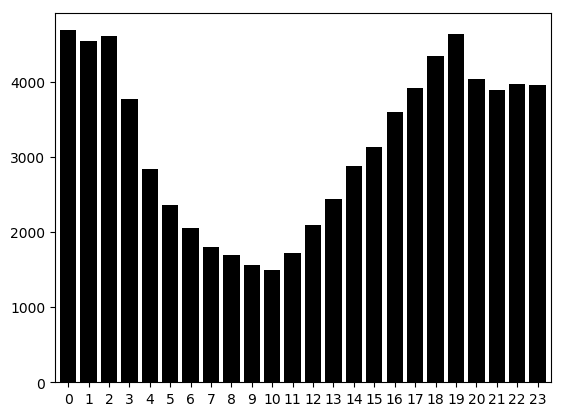

In [115]:
%load solutions/groupby_03.py

<div class="alert alert-success" data-title="Pale Ales">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Pale Ales</h1>
</div>
<p>
Make a variable `pale_ales` that filters `df` to just rows where `beer_style` contains the string `'pale ale'` (ignoring case)
</p>
- Hint: Use the `df.beer_style.str` namespace and find a method for checking whether a string contains another string.

In [117]:
%load solutions/groupby_04.py

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,5.3,93,33,Steel Rail Extra Pale Ale,American Pale Ale (APA),3.5,3.5,4.0,4.0,Todd,4.0,"Presentation: Pint size, on tap from the Easts...",1996-08-22 00:00:01
5,5.5,324,100,McNeill's Champ Ale,American Pale Ale (APA),4.0,3.5,4.0,3.0,Todd,3.5,Presentation: 12 oz. bottle. Another story on ...,1998-02-17 00:00:01
11,5.0,264,6994,Alexander Keith's India Pale Ale,English India Pale Ale (IPA),2.5,2.5,4.0,3.0,Todd,2.5,"Presentation: 12oz brown twisty, with a red st...",1998-04-16 00:00:01
17,7.6,411,112,Pranqster,Belgian Strong Pale Ale,4.0,4.0,5.0,5.0,Todd,5.0,Presentation: 12oz fat twisty with a black&whi...,1998-06-01 00:00:01
30,5.5,6900,495,Nor'Wester Oregon Pale Ale,American Pale Ale (APA),4.0,4.5,4.0,4.0,Jason,4.5,Copper colour on the light side with a decent ...,1998-08-16 09:35:25


# Groupby

Groupby operations come up in a lot of contexts.
At its root, groupby about doing an operation on many subsets of the data, each of which shares something in common.
The components of a groupby operation are:

## Components of a groupby

1. **split** a table into groups
2. **apply** a function to each group
3. **combine** the results into a single DataFrame or Series

In pandas the `split` step looks like

```python
df.groupby( grouper )
```

`grouper` can be many things

- Series (or string indicating a column in `df`)
- function (to be applied on the index)
- dict : groups by *values*
- `levels=[ names of levels in a MultiIndex ]`

## Split

Break a table into smaller logical tables according to some rule

In [118]:
gr = df.groupby("beer_name")
gr

We haven't really done any actual work yet, but pandas knows what it needs to know to break the larger `df` into many smaller pieces, one for each distinct `beer_name`.

## Apply & Combine

To finish the groupby, we apply a method to the groupby object.

In [119]:
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']

df.groupby('beer_name')[review_cols].agg('mean')

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_name,,,,,
"""50"" Golden Anniversary Lager",5.000000,3.500000,4.000000,3.500000,3.500000
"""Alt""ered State",4.000000,3.750000,3.500000,4.000000,4.000000
"""Double Wrecked Wreck"" IPA",3.250000,3.750000,4.000000,4.000000,3.750000
"""Marnie"" Gras Carnival Ale",3.666667,4.333333,3.833333,4.000000,4.000000
"""Old Yeltsin"" Imperial Stout",4.176471,4.088235,3.676471,3.882353,3.970588
...,...,...,...,...,...
Öko Ur-Weizen,3.750000,4.000000,3.500000,3.250000,3.500000
Öko Urtrunk,4.000000,4.000000,4.500000,4.000000,4.000000
Ölsch,4.000000,4.000000,4.500000,4.000000,4.500000


In this case, the function we applied was `'mean'`.
Pandas has implemented cythonized versions of certain common methods like mean, sum, etc.
You can also pass in regular functions like `np.mean`.

In terms of split, apply, combine, split was `df.groupby('beer_name')`. 
We apply the `mean` function by passing in `'mean'`.
Finally, by using the `.agg` method (for aggregate) we tell pandas to combine the results with one output row per group.

You can also pass in regular functions like `np.mean`.

In [120]:
df.groupby('beer_name')[review_cols].agg(np.mean).head()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_name,,,,,
"""50"" Golden Anniversary Lager",5.000000,3.500000,4.000000,3.500000,3.500000
"""Alt""ered State",4.000000,3.750000,3.500000,4.000000,4.000000
"""Double Wrecked Wreck"" IPA",3.250000,3.750000,4.000000,4.000000,3.750000
"""Marnie"" Gras Carnival Ale",3.666667,4.333333,3.833333,4.000000,4.000000
"""Old Yeltsin"" Imperial Stout",4.176471,4.088235,3.676471,3.882353,3.970588


Finally, [certain methods](http://pandas.pydata.org/pandas-docs/stable/api.html#id35) have been attached to `Groupby` objects.

In [121]:
df.groupby('beer_name')[review_cols].mean()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_name,,,,,
"""50"" Golden Anniversary Lager",5.000000,3.500000,4.000000,3.500000,3.500000
"""Alt""ered State",4.000000,3.750000,3.500000,4.000000,4.000000
"""Double Wrecked Wreck"" IPA",3.250000,3.750000,4.000000,4.000000,3.750000
"""Marnie"" Gras Carnival Ale",3.666667,4.333333,3.833333,4.000000,4.000000
"""Old Yeltsin"" Imperial Stout",4.176471,4.088235,3.676471,3.882353,3.970588
...,...,...,...,...,...
Öko Ur-Weizen,3.750000,4.000000,3.500000,3.250000,3.500000
Öko Urtrunk,4.000000,4.000000,4.500000,4.000000,4.000000
Ölsch,4.000000,4.000000,4.500000,4.000000,4.500000


<div class="alert alert-success" data-title="Highest Variance">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Highest Variance</h1>
</div>

<p>Find the `beer_style`s with the greatest variance in `abv`.</p>

- hint: `.var` calculates the varaince and is available on `GroupBy` objects like `gr.abv`.
- hint: use `.sort_values` to sort a Series by the values (it took us a while to come up with that name)

In [126]:
%load solutions/groupby_abv.py

beer_style
American Double / Imperial Stout    13.696583
American Strong Ale                 10.459941
Braggot                              6.856215
American Double / Imperial IPA       4.450049
Old Ale                              4.136272
                                      ...    
Bière de Champagne / Bière Brut      0.055477
Roggenbier                           0.055074
Japanese Rice Lager                  0.028082
Gose                                 0.005333
American Black Ale                   0.000000
Name: abv, Length: 103, dtype: float64

## `.agg` output shape

The output shape is determined by the grouper, data, and aggregation

- Grouper: Controls the output index
    * single grouper -> Index
    * array-like grouper -> MultiIndex
- Subject (Groupee): Controls the output data values
    * single column -> Series (or DataFrame if multiple aggregations)
    * multiple columns -> DataFrame
- Aggregation: Controls the output columns
    * single aggfunc -> Index in the colums
    * multiple aggfuncs -> MultiIndex in the columns (Or 1-D Index if groupee is 1-D)


We'll go into MultiIndexes in a bit, but for know, think of them as regular Indexes with multiple levels (columns).

In [127]:
# single grouper, single groupee, single aggregation
df.groupby('beer_style').review_overall.agg('mean')

beer_style
Altbier                       3.844017
American Adjunct Lager        2.708166
American Amber / Red Ale      3.741607
American Amber / Red Lager    3.455166
American Barleywine           4.005499
                                ...   
Vienna Lager                  3.697218
Weizenbock                    4.040816
Wheatwine                     4.013514
Winter Warmer                 3.792023
Witbier                       3.886922
Name: review_overall, Length: 103, dtype: float64

In [128]:
# multiple groupers, multiple groupee, single aggregation
df.groupby(['brewer_id', 'beer_name'])[review_cols].agg(['mean', 'min', 'max', 'std', 'count'])

review_appearance                      \
                                                  mean  min  max       std   
brewer_id beer_name                                                          
1         Eisbrau Czech                       3.000000  3.0  3.0       NaN   
          Gambrinus                           4.000000  3.5  4.5  0.707107   
          Gambrinus Pale                      3.500000  3.5  3.5       NaN   
          Pilsner Urquell                     3.746575  2.0  5.0  0.507741   
          Primus                              3.000000  3.0  3.0       NaN   
...                                                ...  ...  ...       ...   
24926     Mongozo (Banana)                    4.500000  4.0  5.0  0.408248   
          Mongozo (Palmnut)                   3.894737  2.5  5.0  0.591114   
24964     Haffenreffer Private Stock          3.071429  2.0  4.0  0.786796   
26715     Gageleer                            5.000000  5.0  5.0       NaN   
27039     Heady Topper                        4.333333  4.0  4.5  0.288675   

                                           review_aroma                      \
                                     count         mean  min  max       std   
brewer_id beer_name                                                           
1         Eisbrau Czech                  1     3.000000  3.0  3.0       NaN   
          Gambrinus                      2     4.000000  4.0  4.0  0.000000   
          Gambrinus Pale                 1     3.500000  3.5  3.5       NaN   
          Pilsner Urquell               73     3.383562  1.0  5.0  0.770644   
          Primus                         1     3.500000  3.5  3.5       NaN   
...                                    ...          ...  ...  ...       ...   
24926     Mongozo (Banana)               4     4.625000  4.5  5.0  0.250000   
          Mongozo (Palmnut)             19     3.868421  3.0  5.0  0.466729   
24964     Haffenreffer Private Stock     7     3.000000  2.0  3.5  0.577350   
26715     Gageleer                       1     3.500000  3.5  3.5       NaN   
27039     Heady Topper                   3     4.500000  4.0  5.0  0.500000   

                                            ...  review_palate            \
                                     count  ...           mean  min  max   
brewer_id beer_name                         ...                            
1         Eisbrau Czech                  1  ...       3.500000  3.5  3.5   
          Gambrinus                      2  ...       3.750000  3.0  4.5   
          Gambrinus Pale                 1  ...       3.500000  3.5  3.5   
          Pilsner Urquell               73  ...       3.513699  1.0  5.0   
          Primus                         1  ...       3.000000  3.0  3.0   
...                                    ...  ...            ...  ...  ...   
24926     Mongozo (Banana)               4  ...       3.250000  2.5  4.0   
          Mongozo (Palmnut)             19  ...       3.868421  2.5  4.5   
24964     Haffenreffer Private Stock     7  ...       3.142857  1.5  4.0   
26715     Gageleer                       1  ...       3.500000  3.5  3.5   
27039     Heady Topper                   3  ...       4.666667  4.0  5.0   

                                                     review_taste            \
                                           std count         mean  min  max   
brewer_id beer_name                                                           
1         Eisbrau Czech                    NaN     1     3.500000  3.5  3.5   
          Gambrinus                   1.060660     2     4.000000  4.0  4.0   
          Gambrinus Pale                   NaN     1     3.500000  3.5  3.5   
          Pilsner Urquell             0.676863    73     3.547945  1.0  4.5   
          Primus                           NaN     1     3.000000  3.0  3.0   
...                                        ...   ...          ...  ...  ...   
24926     Mongozo (Banana)            0.645497     4     3.87

<div class="alert alert-success" data-title="Rating by length">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Rating by length</h1>
</div>

<p>Plot the relationship between review length (number of characters) and average `reveiw_overall`.</p>

- Hint: use `.plot(style='k.')`
- We've grouped by columns so far, you can also group by any series with the same length

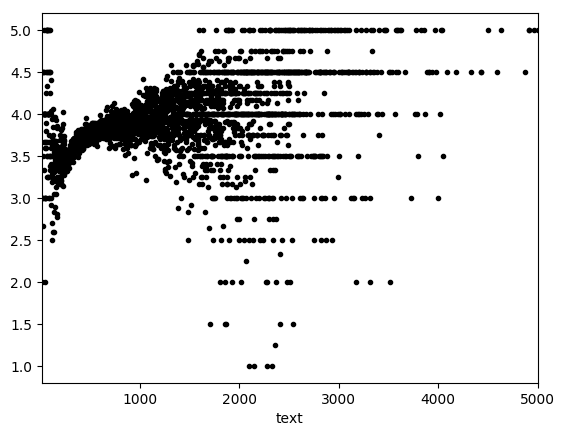

In [42]:
%load solutions/groupby_00.py

<div class="alert alert-success" data-title="Reviews by Length">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Reviews by Length</h1>
</div>

<p>Find the relationship between review length (number of **words** and average `reveiw_overall`.)</p>

- Hint: You can pass a [regular expression](https://docs.python.org/3/howto/regex.html#matching-characters) to any of the `.str` methods.

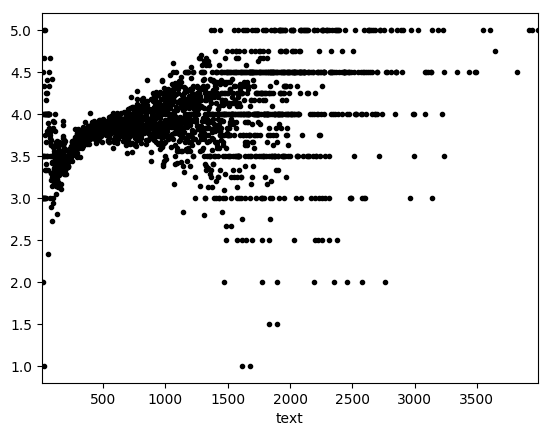

In [44]:
%load solutions/groupby_00b.py

<div class="alert alert-success" data-title="Rating by number of Reviews">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Rating by number of Reviews</h1>
</div>

<p>Find the relationship between the number of reviews for a beer and the average `review_overall`.</p>


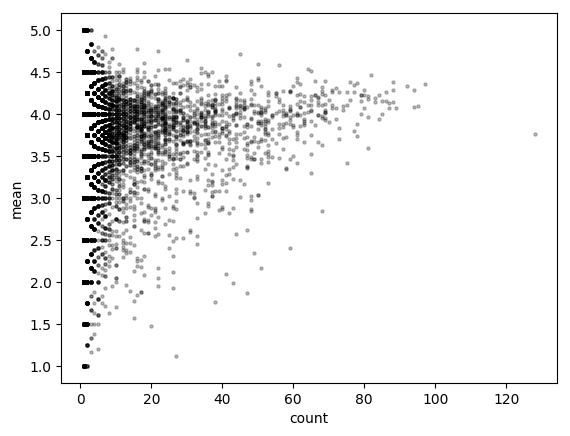

In [46]:
%load solutions/groupby_01.py

## Transform

A *transform* is a function whose output is the same shape as the input.

Recall that a groupby has three steps: split, apply, combine.
So far, all of the functions we've applied have been *aggregations*: the rule for "combine" is one row per group.

You can use `Groupby.transform` when you have an operation that should be done *groupwise*, but the result should be the same shape.
For example, suppose we wanted to de-mean each reviewer's scores by their average score. 

In [47]:
# Define demean(v: array) -> array
def demean(v):
    return v - v.mean()

Just calling `demean` on the entire Series will noramilze by the *global* average.

In [48]:
demean(df.review_overall)

0        0.245731
1        0.245731
2        0.745731
3        0.245731
4        0.245731
           ...   
76009    0.245731
76010    0.745731
76011    1.245731
76012    0.745731
76013   -0.254269
Name: review_overall, Length: 76014, dtype: float64

Now, let's de-mean each individual's reviews by their own average.
This could be useful if, for example, you were building a recommendation system.
A rating of 4 from someone's whose average is 2 is in some sense more meaningful that a 4 from someone who always gives 4s.

In [49]:
normalized = df.groupby("profile_name")[review_cols].transform(demean)
normalized.head()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
0,-0.122437,0.003016,0.231604,0.389023,0.278649
1,-0.622437,0.503016,0.231604,0.889023,0.778649
2,0.755879,0.357983,0.710705,0.068379,0.758663
3,-0.622437,-0.996984,0.231604,-0.110977,-0.221351
4,-0.122437,0.003016,0.231604,-0.110977,0.278649


We used `.transform` because the desired output was the same shape as the input.
Just like `.agg` informs pandas that you want `1 input group → 1 output row`, the `.transform` method informs pandas that you want `1 input row → 1 output row`.

`.transform` operates on each column independently.

<div class="alert alert-success" data-title="Personal Trend?">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Personal Trend?</h1>
</div>

<p>Do reviewer's `review_overall` trend over a person's time reviewing?</p>

Hint: Need an indictor that tracks which review this is for that person. That is, we need a cumulative count of reviews per person.

Implement `cumcount` to match the example

In [147]:
def cumcount(s):
    """Returns an array with counting up to the length of 's'
    
    Examples
    --------
    >>> cumcount([1, 2, 2, 1, 2])
    array([0, 1, 2, 4])
    """
    return ...

cumcount([1, 2, 2, 1, 2])

Now make a variable `order` that has which review it was for that person.
For example, if the raw reviews were like

<table>
  <thead>
      <th>Reviewer</th>
      <th>Review Overall</th>
  </thead>
  <tbody>
      <tr>
          <td>Alice</td>
          <td>3</td>
      </tr>
      <tr>
          <td>Alice</td>
          <td>3</td>
      </tr>
      <tr>
          <td>Bob</td>
          <td>2</td>
      </tr>
      <tr>
          <td>Alice</td>
          <td>4</td>
      </tr>
      <tr>
          <td>Bob</td>
          <td>5</td>
      </tr>
  </tbody>
</table>

The `order` table would be


<table>
  <thead>
      <th>Reviewer</th>
      <th>Order</th>
  </thead>
  <tbody>
      <tr>
          <td>Alice</td>
          <td>0</td>
      </tr>
      <tr>
          <td>Alice</td>
          <td>1</td>
      </tr>
      <tr>
          <td>Bob</td>
          <td>0</td>
      </tr>
      <tr>
          <td>Alice</td>
          <td>2</td>
      </tr>
      <tr>
          <td>Bob</td>
          <td>2</td>
      </tr>
  </tbody>

</table>

In [ ]:
order = df.groupby("profile_name").review_overall.transform(...)
order

Now, what do we do with `order`? Hint: It's the same shape as `df` and we
want to compute the average `review_overall` for all people with `order=0`,
and all people with `order=1`, and `order=2`...

In [ ]:
%load solutions/groupby_02.py

## General `.apply`

We've seen `.agg` for outputting 1 row per group, and `.transform` for outputting 1 row per input row.

The final kind of function application is `.apply`.
This can do pretty much whatever you want.
We'll see an example in a later notebook.

## Summary

- We used Python's iterator protocol to transform the raw data to a table
- We saw how Dask could handle larger-than-memory data with a familiar API
- We used groupby to analyze data by subsets